# Our Experiment Model

Here, we will be modeling our method for store data in DNA. In this method, we are mixing and matching forward and reverse primers. This yields unique pairs of forward and reverse primers where each forward/reverse primer may be used to specify another file as well. When amplifying a target file from the pool, this would mean that some of the files apart from the target file will amplify linearly because they are specified by either the same forward or the same reverse primer. The goal of our modelling is to see the effect this linear amplification has on the amount of target file amplified and how this changes and the system is scaled up by using more forward and reverse files to specify more files.

In [6]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import statistics
from matplotlib.widgets import Slider  # import the Slider widget


## PCR/Random Access Simulation

Both target and nontarget files are being amplified. Target files are amplified exponentially because both forward and reverse primers attach to it. On the other hand nontarget files amplify linearly because either a forward primer or a reverse primer attaches to it.

These are some of the main values that will be plotted:
* target vs. nontarget - ratio of # of strands of the target files for to that of the nontarget files
* %target - percentage of target file strands in the solution
* amplification ratio - ratio of amount of template in current cycle to that of the previous cycle

In [7]:
# this function takes in: 
# --- number of primers that are being used to specify files - for example, if 9 is inputted, there are 9 forward primers
# -------- and 9 reverse primers being used to store 9*9=81 files
# --- the number of cycles the PCR reaction will run for (e.g., 18)

def calcPercTarg(primersC, cycleEnd): 
    #initialize variables before the cycles begin
    files=primersC**2 # no. files
    initTarg= 0.001 / files # amount of inital target file in uL before the PCR begins
    ntLin = (primersC * 2) - 2 # no. files being amplified linearly
    initNTLin = 0.001 * (ntLin/files) # amount of nontarget files being amplified linearly in uL before PCR begins
    NA = 0.001 * (files - ntLin - 1)/ files # amount of nontarget files that will not be affected

    # creating lists
    target = [initTarg] # stores amounts of target file in uL after each PCR cycle
    ratios = [None]
    targToNonT = [initTarg/initNTLin]
    primer=[10]
    nontarget = [initNTLin]
    total=[initTarg + initNTLin + NA] # stores total amount of template/files in the solution in uL after each cycle
    cycles = [0]
    percent=[(target[0]/total[0])*100]

    # PCR simulation
    for cycle in range(1,cycleEnd + 1): # go through the cycles as per the parameter inputted into this function
        cycles.append(cycle) 
        target.append(target[cycle-1] * 2) # exponential growth of target file
        nontarget.append(cycle * initNTLin) # linear amplific

        total.append(target[cycle] + nontarget[cycle] + NA)
        targToNonT.append(target[cycle]/nontarget[cycle])
        percent.append((target[cycle]/total[cycle])*100)
        ratios.append(total[cycle]/total[cycle - 1])
        change = total[cycle] - total[cycle-1]
        primer.append(primer[cycle-1] - change)

    return target, nontarget, percent, primer, total, cycles, ratios


In [8]:
target, nontarget, percent, primer, total, cycles, ratios = calcPercTarg(9, 30) # run the simulation using 9 forward and 9
                                                                                # and 9 reverse primers (81 files) for 30 cycles

### Modeling Changes to Amplification of Target after Changing No. Files Addressed

Here, we create a plot that shows how the percentage of target files in the solution after 18 cycles, changes as we use more forward and reverse primers to specify more files.

In [9]:
# returns the expected %target after the given number of cycles
def perTarg(cycle, primersN):
    target = 2**cycle/2
    nontarget = cycle*(primersN * 2 - 2)
    total = target+nontarget
    return((target/total) * 100)
print(perTarg(18, 9))

99.7807551766139


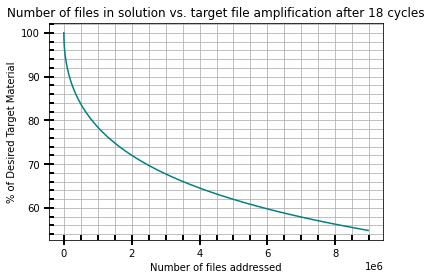

In [10]:
X = []
Y = []
maxFiles = 3000
for x in range(0, maxFiles, 5):
    X.append(x*x)
    Y.append(perTarg(18, x))

#plot the graph!
plt.plot(X, Y, color='teal')

#add labels
plt.xlabel('Number of files addressed')
plt.ylabel('% of Desired Target Material')
plt.title('Number of files in solution vs. target file amplification after 18 cycles')

#set up ticks and grid
plt.minorticks_on()
plt.tick_params(which='major', length=10, width=2, direction='inout')
plt.tick_params(which='minor', length=5, width=2, direction='in')
plt.grid(which='both')

#present! 
plt.show()

## Plot Model vs. Graph
#### Import the Data

Here, we are plotting the data from the PCR run where we amplified the file specified by FP7 and RP8.

In [11]:
df = pd.read_csv("7-8 Data.csv")
df = df[3:29]
cyclesData=df['Cycle']
avgRatio=df['Ratio Avg']
ratioErr=df['Ratio Error']
drnAvg=df['Avg Delta Rn']
drnErr=df['DRn Error']


#### Plot the Data

Text(0.5, 1.0, 'Compare shapes of template amp.')

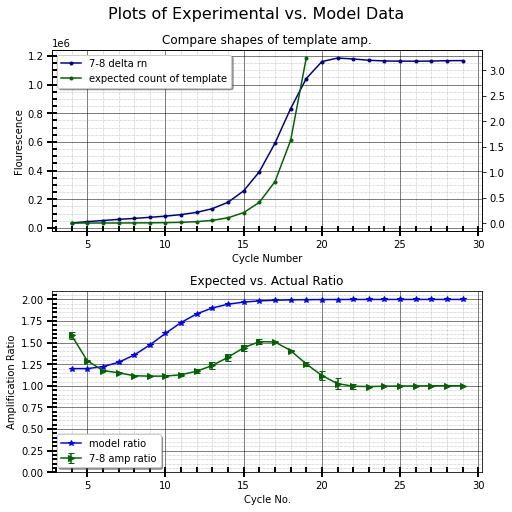

In [12]:
fig, ax = plt.subplots(2, figsize=(7,7), constrained_layout=True)
fig.suptitle("Plots of Experimental vs. Model Data", fontsize=16)


##### PLOT model ratio vs 7-8 amp. ratio
ax[1].errorbar(cyclesData, avgRatio, yerr=ratioErr, capsize=3, color = 'darkgreen', label='7-8 amp ratio', marker='>')
ax[1].plot(cyclesData[0:26], ratios[3:29], color='blue', label='model ratio', marker='*')
ax[1].set_ylim(0, 2.1)
ax[1].legend(shadow=True, fancybox=True,loc='lower left')
ax[1].set_xlabel('Cycle No.')
ax[1].set_ylabel('Amplification Ratio')

#set up ticks and grid
ax[1].minorticks_on()
ax[1].tick_params(which='major', length=10, width=2, direction='inout')
ax[1].tick_params(which='minor', length=5, width=2, direction='in')
ax[1].grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax[1].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
5
ax[1].set_title('Expected vs. Actual Ratio')

###### PLOT compare shapes of expected vs. actual # TODO: get the legend nice!
# l2=ax[0].errorbar(cyclesData, drnAvg, yerr=drnErr, capsize=3, color = 'darkblue', label='7-8 delta rn', marker='.')
l2=ax[0].plot(cyclesData, drnAvg, color = 'darkblue', label='7-8 delta rn', marker='.')

ax3=ax[0].twinx()
l1= ax3.plot(cyclesData[0:16], total[3:19], color = 'darkgreen', label='expected count of template', marker='.')
ax[0].set_xlabel('Cycle Number')
ax[0].set_ylabel('Flourescence')
# ax[0].legend(shadow=True, fancybox=True,loc='best')
# ax3.legend(shadow=True, fancybox=True,loc='upper left')
lns=l2+l1
labs = [l.get_label() for l in lns]
ax[0].legend(lns,labs,loc='upper left', fancybox=True, shadow=True)
#set up ticks and grid
ax[0].minorticks_on()
ax[0].tick_params(which='major', length=10, width=2, direction='inout')
ax[0].tick_params(which='minor', length=5, width=2, direction='in')
ax[0].grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax[0].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

ax[0].set_title('Compare shapes of template amp.')